In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import gc
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/ieee-fraud-detection/test_identity.csv
/kaggle/input/ieee-fraud-detection/sample_submission.csv
/kaggle/input/ieee-fraud-detection/train_identity.csv
/kaggle/input/ieee-fraud-detection/train_transaction.csv
/kaggle/input/ieee-fraud-detection/test_transaction.csv


## For Visualization

In [2]:
import altair as alt
from altair.vega import v5
from IPython.display import HTML

def prepare_altair():
    """
    Helper function to prepare altair for working.
    """

    vega_url = 'https://cdn.jsdelivr.net/npm/vega@' + v5.SCHEMA_VERSION
    vega_lib_url = 'https://cdn.jsdelivr.net/npm/vega-lib'
    vega_lite_url = 'https://cdn.jsdelivr.net/npm/vega-lite@' + alt.SCHEMA_VERSION
    vega_embed_url = 'https://cdn.jsdelivr.net/npm/vega-embed@3'
    noext = "?noext"
    
    paths = {
        'vega': vega_url + noext,
        'vega-lib': vega_lib_url + noext,
        'vega-lite': vega_lite_url + noext,
        'vega-embed': vega_embed_url + noext
    }
    
    workarounds = f"""    requirejs.config({{
        baseUrl: 'https://cdn.jsdelivr.net/npm/',
        paths: {paths}
    }});
    """
    
    return workarounds

def add_autoincrement(render_func):
    # Keep track of unique <div/> IDs
    cache = {}
    def wrapped(chart, id="vega-chart", autoincrement=True):
        if autoincrement:
            if id in cache:
                counter = 1 + cache[id]
                cache[id] = counter
            else:
                cache[id] = 0
            actual_id = id if cache[id] == 0 else id + '-' + str(cache[id])
        else:
            if id not in cache:
                cache[id] = 0
            actual_id = id
        return render_func(chart, id=actual_id)
    # Cache will stay outside and 
    return wrapped

@add_autoincrement
def render(chart, id="vega-chart"):
    """
    Helper function to plot altair visualizations.
    """
    chart_str = """
    <div id="{id}"></div><script>
    require(["vega-embed"], function(vg_embed) {{
        const spec = {chart};     
        vg_embed("#{id}", spec, {{defaultStyle: true}}).catch(console.warn);
        console.log("anything?");
    }});
    console.log("really...anything?");
    </script>
    """
    return HTML(
        chart_str.format(
            id=id,
            chart=json.dumps(chart) if isinstance(chart, dict) else chart.to_json(indent=None)
        )
    )

# setting up altair
workaround = prepare_altair()
HTML("".join((
    "<script>",
    workaround,
    "</script>",
)))

We are dealing with the really big files that's why it will be better to use a function which can reduce the memory of the dataframe

In [4]:
## Function to reduce the DF size
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [5]:
%matplotlib inline

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LogisticRegression

In [6]:
%%time
train_identity = pd.read_csv('/kaggle/input/ieee-fraud-detection/train_identity.csv')
test_identity = pd.read_csv('/kaggle/input/ieee-fraud-detection/test_identity.csv')
train_transaction = pd.read_csv('/kaggle/input/ieee-fraud-detection/train_transaction.csv')
test_transaction = pd.read_csv('/kaggle/input/ieee-fraud-detection/test_transaction.csv')

CPU times: user 50.4 s, sys: 14.2 s, total: 1min 4s
Wall time: 1min 4s


In [7]:
%%time
train_identity = reduce_mem_usage(train_identity)
test_identity = reduce_mem_usage(test_identity)
train_transaction = reduce_mem_usage(train_transaction)
test_transaction = reduce_mem_usage(test_transaction)

Mem. usage decreased to 25.86 Mb (42.7% reduction)
Mem. usage decreased to 25.44 Mb (42.7% reduction)
Mem. usage decreased to 542.35 Mb (69.4% reduction)
Mem. usage decreased to 472.59 Mb (68.9% reduction)
CPU times: user 1min 47s, sys: 4min 31s, total: 6min 18s
Wall time: 6min 18s


We need to merge both identity and transactions on the same column "TransactionID", since identity refers to which type of device we used for transactions and transactions shows what transactions we made like the amount of transaction, card type etc.

After merging them it will be better to delete both csv files from the memory since they will be occupying the unnecessary space on the disk which may lead to memory error.

In [9]:
%%time
train = pd.merge(train_transaction, train_identity, on='TransactionID', how='left')
test = pd.merge(test_transaction, test_identity, on='TransactionID', how='left')

CPU times: user 6.42 s, sys: 444 ms, total: 6.86 s
Wall time: 6.86 s


In [10]:
del train_identity, train_transaction, test_identity, test_transaction

In [11]:
missing_values = train.notnull().sum().sort_values(ascending=False)
missing_per = ((missing_values)/len(train)) * 100
pd.concat([missing_values, missing_per], keys=['Missing Values', 'Not Missing %'], axis=1)

,Missing Values,Not Missing %
TransactionID,590540,100.000000
C9,590540,100.000000
C1,590540,100.000000
C2,590540,100.000000
C3,590540,100.000000
C4,590540,100.000000
C5,590540,100.000000
C6,590540,100.000000
card1,590540,100.000000
C8,590540,100.000000


## Deleting the data which is above 90% missing

In [12]:
def delete_too_much_missing_data(data):
    too_much_null_cols = [col for col in data.columns if data[col].isnull().sum()/data.shape[0]>0.9]
    return too_much_null_cols

let's see if we have repeated data or not.

In [13]:
dupes = train.duplicated()
sum(dupes)

0

Nope, we don't.
But let's see if we have repeated values in each feature vector or not.

In [14]:
repeated_vals = [col for col in train.columns if train[col].value_counts(dropna=False, normalize=True).values[0] > 0.9]
repeated_vals

['isFraud',
 'dist2',
 'C3',
 'D7',
 'V98',
 'V101',
 'V102',
 'V103',
 'V104',
 'V105',
 'V106',
 'V107',
 'V108',
 'V109',
 'V110',
 'V111',
 'V112',
 'V113',
 'V114',
 'V115',
 'V116',
 'V117',
 'V118',
 'V119',
 'V120',
 'V121',
 'V122',
 'V123',
 'V124',
 'V125',
 'V129',
 'V132',
 'V133',
 'V134',
 'V135',
 'V136',
 'V137',
 'V281',
 'V284',
 'V286',
 'V290',
 'V293',
 'V295',
 'V296',
 'V297',
 'V298',
 'V299',
 'V300',
 'V301',
 'V305',
 'V309',
 'V311',
 'V316',
 'V318',
 'V319',
 'V320',
 'V321',
 'id_07',
 'id_08',
 'id_18',
 'id_21',
 'id_22',
 'id_23',
 'id_24',
 'id_25',
 'id_26',
 'id_27']

Converting this into a function

In [15]:
def get_too_many_repeated_val(data):
    big_top_value_cols = [col for col in data.columns if data[col].value_counts(dropna=False, normalize=True).values[0] > 0.9]
    return big_top_value_cols

In [16]:
def get_useless_columns(data, target):
    too_many_null = delete_too_much_missing_data(data)
    print("More than 90% null: " + str(len(too_many_null)))
    too_many_repeated = get_too_many_repeated_val(data)
    print("More than 90% repeated value: " + str(len(too_many_repeated)))
    cols_to_drop = list(set(too_many_null + too_many_repeated))
    cols_to_drop.remove(target)
    return cols_to_drop

In [17]:
cols_to_drop = get_useless_columns(train, 'isFraud')

More than 90% null: 12
More than 90% repeated value: 67


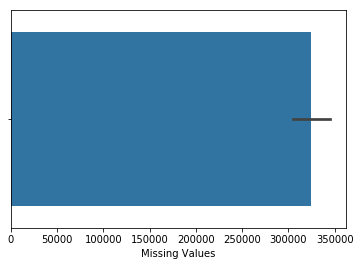

In [18]:
missing_data = pd.concat([missing_values, missing_per], keys=['Missing Values', 'Not Missing %'], axis=1)
sns.barplot(missing_data['Missing Values'], data=missing_data)

### ID columns seems to be having alot of missing let's take a peek at them.

In [19]:
for i in range(1, 10):
    print(train['id_0' + str(i)].value_counts(dropna=False, normalize=True).head())
    print('\n')
    
for i in range(10, 39):
    print(train['id_' + str(i)].value_counts(dropna=False, normalize=True).head())
    print('\n')

 NaN     0.755761
-5.0     0.139144
 0.0     0.033114
-10.0    0.019062
-20.0    0.018984
Name: id_01, dtype: float64


NaN       0.761452
1102.0    0.000019
696.0     0.000017
1116.0    0.000015
1120.0    0.000015
Name: id_02, dtype: float64


NaN    0.887689
0.0    0.108211
1.0    0.001461
3.0    0.001131
2.0    0.000713
Name: id_03, dtype: float64


 NaN    0.887689
 0.0    0.111320
-5.0    0.000224
-6.0    0.000166
-8.0    0.000108
Name: id_04, dtype: float64


NaN    0.768238
0.0    0.157048
1.0    0.014043
2.0    0.008360
3.0    0.006526
Name: id_05, dtype: float64


 NaN    0.768238
 0.0    0.154647
-1.0    0.007937
-5.0    0.006518
-6.0    0.005515
Name: id_06, dtype: float64


NaN     0.991271
0.0     0.000693
16.0    0.000415
14.0    0.000386
12.0    0.000352
Name: id_07, dtype: float64


 NaN      0.991271
-100.0    0.000847
 0.0      0.000442
-34.0     0.000435
-33.0     0.000354
Name: id_08, dtype: float64


NaN    0.873123
0.0    0.119176
1.0    0.002736
3.0    0.001636
2

### Visualizing the categorical values.

id from 12 to 38 is a categorical values.

In [20]:
charts = {}
info = []
for i in range(12, 39):
    info.append('id_' + str(i))
for i in info:
    width_len = 400
    if i in ['id_30', 'id_31', 'id_33']:
        width_len = 600
    feature_count = train[i].value_counts(dropna=False).reset_index().rename(columns={i: 'count', 'index': i})
    chart = alt.Chart(feature_count).mark_bar().encode(
                y=alt.Y(f"{i}:N", axis=alt.Axis(title=i)),
                x=alt.X('count:Q', axis=alt.Axis(title='Count')),
                tooltip=[i, 'count']
            ).properties(title=f"Counts of {i}", width=width_len)
    charts[i] = chart                         


for i in ['id_30', 'id_31', 'id_33']:
    feature_count = train[i].value_counts(dropna=False)[:40].reset_index().rename(columns={i: 'count', 'index': i})
    chart = alt.Chart(feature_count).mark_bar().encode(
                x=alt.X(f"{i}:N", axis=alt.Axis(title=i)),
                y=alt.Y('count:Q', axis=alt.Axis(title='Count')),
                tooltip=[i, 'count']
            ).properties(title=f"Counts of {i}", width=800)
    charts[i] = chart
render((charts['id_12'] | charts['id_15']) & 
       (charts['id_16'] | charts['id_23']) & 
       (charts['id_27'] | charts['id_28']) & 
       (charts['id_29'] | charts['id_34']) & 
       (charts['id_35'] | charts['id_36']) &
       (charts['id_37'] | charts['id_38']))

In [21]:
render(charts['id_30'] & charts['id_31'] & charts['id_33'])

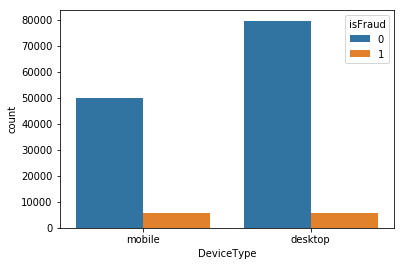

In [22]:
sns.countplot(train['DeviceType'], hue='isFraud', data=train)

## Cards

In [23]:
for i in range(1, 7):
    print(train['card' + str(i)].value_counts(dropna=False, normalize=True).head())
    print('\n')

7919     0.025285
9500     0.023981
15885    0.017545
17188    0.017516
15066    0.013454
Name: card1, dtype: float64


321.0    0.082865
111.0    0.076525
555.0    0.071113
490.0    0.064593
583.0    0.036920
Name: card2, dtype: float64


150.0    0.882729
185.0    0.095414
106.0    0.002660
NaN      0.002650
146.0    0.002120
Name: card3, dtype: float64


visa                0.651551
mastercard          0.320414
american express    0.014102
discover            0.011263
NaN                 0.002670
Name: card4, dtype: float64


226.0    0.502161
224.0    0.138031
166.0    0.096759
102.0    0.049285
117.0    0.043928
Name: card5, dtype: float64


debit              0.744976
credit             0.252288
NaN                0.002660
debit or credit    0.000051
charge card        0.000025
Name: card6, dtype: float64




In [24]:
for i in range(1, 15):
    print(train['C' + str(i)].value_counts(dropna=False, normalize=True).head())
    print('\n')

1.0    0.536443
2.0    0.177924
3.0    0.086895
4.0    0.048845
5.0    0.030348
Name: C1, dtype: float64


1.0    0.535545
2.0    0.176022
3.0    0.087666
4.0    0.047839
5.0    0.028738
Name: C2, dtype: float64


0.0    0.995887
1.0    0.003619
2.0    0.000305
3.0    0.000098
4.0    0.000012
Name: C3, dtype: float64


0.0    0.765203
1.0    0.189347
2.0    0.022004
3.0    0.008380
4.0    0.003221
Name: C4, dtype: float64


0.0    0.630669
1.0    0.208086
2.0    0.058888
3.0    0.022334
4.0    0.011562
Name: C5, dtype: float64


1.0    0.578372
2.0    0.145804
0.0    0.083087
3.0    0.060098
4.0    0.030150
Name: C6, dtype: float64


0.0    0.885871
1.0    0.087997
2.0    0.012385
3.0    0.003443
4.0    0.001878
Name: C7, dtype: float64


0.0    0.758064
1.0    0.177793
2.0    0.026970
3.0    0.009302
4.0    0.004770
Name: C8, dtype: float64


1.0    0.387676
0.0    0.311232
2.0    0.131793
3.0    0.055043
4.0    0.027426
Name: C9, dtype: float64


0.0    0.767843
1.0    0.169728
2.0  

In [25]:
for i in range(1, 16):
    print(train['D' + str(i)].value_counts(dropna=False, normalize=True).head())
    print('\n')

0.0    0.474362
1.0    0.014621
2.0    0.008414
3.0    0.006696
4.0    0.006045
Name: D1, dtype: float64


NaN    0.475492
0.0    0.025610
1.0    0.011268
2.0    0.007542
3.0    0.006227
Name: D2, dtype: float64


NaN    0.445149
0.0    0.123775
1.0    0.035998
2.0    0.023350
7.0    0.022556
Name: D3, dtype: float64


NaN    0.286047
0.0    0.282066
1.0    0.009000
2.0    0.005732
3.0    0.004355
Name: D4, dtype: float64


NaN    0.524674
0.0    0.110707
1.0    0.025878
2.0    0.017347
7.0    0.016483
Name: D5, dtype: float64


NaN      0.876068
0.0      0.077526
1.0      0.002689
256.0    0.001516
2.0      0.001448
Name: D6, dtype: float64


NaN    0.934099
0.0    0.035789
1.0    0.002908
2.0    0.001690
3.0    0.001339
Name: D7, dtype: float64


NaN         0.873123
0.791504    0.002288
0.833496    0.002247
0.875000    0.002208
0.958496    0.002201
Name: D8, dtype: float64


NaN         0.873123
0.791504    0.009124
0.833496    0.008929
0.750000    0.008716
0.708496    0.008690
Name

In [26]:
for i in range(1, 10):
    print(train['M' + str(i)].value_counts(dropna=False, normalize=True).head())
    print('\n')

T      0.540886
NaN    0.459071
F      0.000042
Name: M1, dtype: float64


T      0.483402
NaN    0.459071
F      0.057527
Name: M2, dtype: float64


NaN    0.459071
T      0.426273
F      0.114656
Name: M3, dtype: float64


NaN    0.476588
M0     0.332585
M2     0.101373
M1     0.089454
Name: M4, dtype: float64


NaN    0.593494
F      0.224356
T      0.182150
Name: M5, dtype: float64


F      0.385843
T      0.327368
NaN    0.286788
Name: M6, dtype: float64


NaN    0.586353
F      0.357933
T      0.055713
Name: M7, dtype: float64


NaN    0.586331
F      0.262897
T      0.150772
Name: M8, dtype: float64


NaN    0.586331
T      0.348251
F      0.065418
Name: M9, dtype: float64




## Visualization of M values

In [27]:
charts = {}
info = []
for i in range(1, 10):
    info.append('M' + str(i))
for i in info:
    feature_count = train[i].value_counts(dropna=False).reset_index().rename(columns={i: 'count', 'index': i})
    chart = alt.Chart(feature_count).mark_bar().encode(
                y=alt.Y(f"{i}:N", axis=alt.Axis(title=i)),
                x=alt.X('count:Q', axis=alt.Axis(title='Count')),
                tooltip=[i, 'count']
            ).properties(title=f"Counts of {i}", width=400)
    charts[i] = chart                         
    
render((charts['M1'] | charts['M2'] | charts['M3']) & (charts['M4'] | charts['M5'] | charts['M6']) & (charts['M7'] | charts['M8'] | charts['M9']))

## Feature engineering

In [28]:
def adding_uid(data):
    data['uid1'] = data['card1'].astype(str)+'_'+data['card2'].astype(str)
    data['uid2'] = data['uid1'].astype(str)+'_'+data['card3'].astype(str)+'_'+data['card5'].astype(str)
    data['uid3'] = data['uid2'].astype(str)+'_'+data['addr1'].astype(str)+'_'+data['addr2'].astype(str)
    return data

In [29]:
train = adding_uid(train)
test = adding_uid(test)

In [30]:
i_cols = ['card1','card2','card3','card5','uid1','uid2','uid3']

for col in i_cols:
    for agg_type in ['mean','std']:
        new_col_name = col+'_TransactionAmt_'+agg_type
        temp_df = pd.concat([train[[col, 'TransactionAmt']], test[[col,'TransactionAmt']]])
        #temp_df['TransactionAmt'] = temp_df['TransactionAmt'].astype(int)
        temp_df = temp_df.groupby([col])['TransactionAmt'].agg([agg_type]).reset_index().rename(
                                                columns={agg_type: new_col_name})

        temp_df.index = list(temp_df[col])
        temp_df = temp_df[new_col_name].to_dict()   

        train[new_col_name] = train[col].map(temp_df)
        test[new_col_name]  = test[col].map(temp_df)

In [31]:
train = train.replace(np.inf,999)
test = test.replace(np.inf,999)

In [32]:
train.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,card3_TransactionAmt_mean,card3_TransactionAmt_std,card5_TransactionAmt_mean,card5_TransactionAmt_std,uid1_TransactionAmt_mean,uid1_TransactionAmt_std,uid2_TransactionAmt_mean,uid2_TransactionAmt_std,uid3_TransactionAmt_mean,uid3_TransactionAmt_std
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,...,147.625,255.25,185.250,999.000,258.0000,210.7500,258.0000,210.7500,193.0000,176.1250
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,...,147.625,255.25,212.750,999.000,213.6250,999.0000,213.6250,999.0000,240.0000,999.0000
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,...,147.625,255.25,98.750,141.125,104.8125,130.3750,104.8125,130.3750,65.6875,55.1875
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,...,147.625,255.25,124.375,191.875,120.9375,196.7500,120.9375,196.7500,113.0625,211.7500
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,...,147.625,255.25,212.750,999.000,99.8125,69.8125,99.8125,69.8125,50.0000,NaN


In [33]:
train['TransactionAmt'] = np.log1p(train['TransactionAmt'])
test['TransactionAmt'] = np.log1p(test['TransactionAmt'])
train.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,card3_TransactionAmt_mean,card3_TransactionAmt_std,card5_TransactionAmt_mean,card5_TransactionAmt_std,uid1_TransactionAmt_mean,uid1_TransactionAmt_std,uid2_TransactionAmt_mean,uid2_TransactionAmt_std,uid3_TransactionAmt_mean,uid3_TransactionAmt_std
0,2987000,0,86400,4.242188,W,13926,NaN,150.0,discover,142.0,...,147.625,255.25,185.250,999.000,258.0000,210.7500,258.0000,210.7500,193.0000,176.1250
1,2987001,0,86401,3.400391,W,2755,404.0,150.0,mastercard,102.0,...,147.625,255.25,212.750,999.000,213.6250,999.0000,213.6250,999.0000,240.0000,999.0000
2,2987002,0,86469,4.093750,W,4663,490.0,150.0,visa,166.0,...,147.625,255.25,98.750,141.125,104.8125,130.3750,104.8125,130.3750,65.6875,55.1875
3,2987003,0,86499,3.931641,W,18132,567.0,150.0,mastercard,117.0,...,147.625,255.25,124.375,191.875,120.9375,196.7500,120.9375,196.7500,113.0625,211.7500
4,2987004,0,86506,3.931641,H,4497,514.0,150.0,mastercard,102.0,...,147.625,255.25,212.750,999.000,99.8125,69.8125,99.8125,69.8125,50.0000,NaN


## Handling Email Domains

In [34]:
emails = {'gmail': 'google', 'att.net': 'att', 'twc.com': 'spectrum', 'scranton.edu': 'other', 'optonline.net': 'other',
          'hotmail.co.uk': 'microsoft', 'comcast.net': 'other', 'yahoo.com.mx': 'yahoo', 'yahoo.fr': 'yahoo',
          'yahoo.es': 'yahoo', 'charter.net': 'spectrum', 'live.com': 'microsoft', 'aim.com': 'aol', 'hotmail.de': 'microsoft',
          'centurylink.net': 'centurylink', 'gmail.com': 'google', 'me.com': 'apple', 'earthlink.net': 'other', 
          'gmx.de': 'other', 'web.de': 'other', 'cfl.rr.com': 'other', 'hotmail.com': 'microsoft', 'protonmail.com': 'other',
          'hotmail.fr': 'microsoft', 'windstream.net': 'other', 'outlook.es': 'microsoft', 'yahoo.co.jp': 'yahoo',
          'yahoo.de': 'yahoo', 'servicios-ta.com': 'other', 'netzero.net': 'other', 'suddenlink.net': 'other',
          'roadrunner.com': 'other', 'sc.rr.com': 'other', 'live.fr': 'microsoft', 'verizon.net': 'yahoo',
          'msn.com': 'microsoft', 'q.com': 'centurylink', 'prodigy.net.mx': 'att', 'frontier.com': 'yahoo',
          'anonymous.com': 'other', 'rocketmail.com': 'yahoo', 'sbcglobal.net': 'att', 'frontiernet.net': 'yahoo',
          'ymail.com': 'yahoo', 'outlook.com': 'microsoft', 'mail.com': 'other', 'bellsouth.net': 'other',
          'embarqmail.com': 'centurylink', 'cableone.net': 'other', 'hotmail.es': 'microsoft', 'mac.com': 'apple',
          'yahoo.co.uk': 'yahoo', 'netzero.com': 'other', 'yahoo.com': 'yahoo', 'live.com.mx': 'microsoft', 'ptd.net': 'other',
          'cox.net': 'other', 'aol.com': 'aol', 'juno.com': 'other', 'icloud.com': 'apple'}
us_emails = ['gmail', 'net', 'edu']

for c in ['P_emaildomain', 'R_emaildomain']:
    train[c + '_bin'] = train[c].map(emails)
    test[c + '_bin'] = test[c].map(emails)
    
    train[c + '_suffix'] = train[c].map(lambda x: str(x).split('.')[-1])
    test[c + '_suffix'] = test[c].map(lambda x: str(x).split('.')[-1])
    
    train[c + '_suffix'] = train[c + '_suffix'].map(lambda x: x if str(x) not in us_emails else 'us')
    test[c + '_suffix'] = test[c + '_suffix'].map(lambda x: x if str(x) not in us_emails else 'us')

Checking if the P domains is matching with the R domains or not. If yes we are assigning 1 and 0 if not on the newly made column.

In [35]:
p = 'P_emaildomain'
r = 'R_emaildomain'
unknown = 'unknown'

def setDomain(data):
    data[p] = data[p].fillna(unknown)
    data[r] = data[r].fillna(unknown)
    
    ## Where P domain matches R.
    ## putting 1 on the email_same col otherwise 0.
    data['email_same'] = np.where((data[p] == data[r]) & (data[p] != unknown), 1, 0)
    data[p+'_prefix'] = data[p].apply(lambda x: x.split('.')[0])
    data[r+'_prefix'] = data[r].apply(lambda x: x.split('.')[0])
    return data

train = setDomain(train)
test = setDomain(test)

## Time

In [36]:
from datetime import datetime
from datetime import timedelta

START_DATE = datetime.strptime('2017-11-30', '%Y-%m-%d')

def setTime(df):
    df['TransactionDT'] = df['TransactionDT'].fillna(df['TransactionDT'].median())
    # Temporary
    df['DT'] = df['TransactionDT'].apply(lambda x: (START_DATE + timedelta(seconds = x)))
    df['DT_M'] = (df['DT'].dt.year-2017)*12 + df['DT'].dt.month
    df['DT_W'] = (df['DT'].dt.year-2017)*52 + df['DT'].dt.weekofyear
    df['DT_D'] = (df['DT'].dt.year-2017)*365 + df['DT'].dt.dayofyear
    
    df['DT_hour'] = df['DT'].dt.hour
    df['DT_day_week'] = df['DT'].dt.dayofweek
    df['DT_day'] = df['DT'].dt.day
    
    # Lets transform D8 and D9 column
    # As we almost sure it has connection with hours
    df['D9_not_na'] = np.where(df['D9'].isna(),0,1)
    df['D8_not_same_day'] = np.where(df['D8']>=1,1,0)
    df['D8_D9_decimal_dist'] = df['D8'].fillna(0)-df['D8'].fillna(0).astype(int)
    df['D8_D9_decimal_dist'] = ((df['D8_D9_decimal_dist']-df['D9'])**2)**0.5
    df['D8'] = df['D8'].fillna(-1).astype(int)

    return df

train = setTime(train)
test = setTime(test)

## Browser Version

In [37]:
train["lastest_browser"] = np.zeros(train.shape[0])
test["lastest_browser"] = np.zeros(test.shape[0])

def setBrowser(df):
    df.loc[df["id_31"]=="samsung browser 7.0",'lastest_browser']=1
    df.loc[df["id_31"]=="opera 53.0",'lastest_browser']=1
    df.loc[df["id_31"]=="mobile safari 10.0",'lastest_browser']=1
    df.loc[df["id_31"]=="google search application 49.0",'lastest_browser']=1
    df.loc[df["id_31"]=="firefox 60.0",'lastest_browser']=1
    df.loc[df["id_31"]=="edge 17.0",'lastest_browser']=1
    df.loc[df["id_31"]=="chrome 69.0",'lastest_browser']=1
    df.loc[df["id_31"]=="chrome 67.0 for android",'lastest_browser']=1
    df.loc[df["id_31"]=="chrome 63.0 for android",'lastest_browser']=1
    df.loc[df["id_31"]=="chrome 63.0 for ios",'lastest_browser']=1
    df.loc[df["id_31"]=="chrome 64.0",'lastest_browser']=1
    df.loc[df["id_31"]=="chrome 64.0 for android",'lastest_browser']=1
    df.loc[df["id_31"]=="chrome 64.0 for ios",'lastest_browser']=1
    df.loc[df["id_31"]=="chrome 65.0",'lastest_browser']=1
    df.loc[df["id_31"]=="chrome 65.0 for android",'lastest_browser']=1
    df.loc[df["id_31"]=="chrome 65.0 for ios",'lastest_browser']=1
    df.loc[df["id_31"]=="chrome 66.0",'lastest_browser']=1
    df.loc[df["id_31"]=="chrome 66.0 for android",'lastest_browser']=1
    df.loc[df["id_31"]=="chrome 66.0 for ios",'lastest_browser']=1
    return df

train=setBrowser(train)
test=setBrowser(test)

## Device Types

In [38]:

def setDevice(df):
    df['DeviceInfo'] = df['DeviceInfo'].fillna('unknown_device').str.lower()
    
    df['device_name'] = df['DeviceInfo'].str.split('/', expand=True)[0]

    df.loc[df['device_name'].str.contains('SM', na=False), 'device_name'] = 'Samsung'
    df.loc[df['device_name'].str.contains('SAMSUNG', na=False), 'device_name'] = 'Samsung'
    df.loc[df['device_name'].str.contains('GT-', na=False), 'device_name'] = 'Samsung'
    df.loc[df['device_name'].str.contains('Moto G', na=False), 'device_name'] = 'Motorola'
    df.loc[df['device_name'].str.contains('Moto', na=False), 'device_name'] = 'Motorola'
    df.loc[df['device_name'].str.contains('moto', na=False), 'device_name'] = 'Motorola'
    df.loc[df['device_name'].str.contains('LG-', na=False), 'device_name'] = 'LG'
    df.loc[df['device_name'].str.contains('rv:', na=False), 'device_name'] = 'RV'
    df.loc[df['device_name'].str.contains('HUAWEI', na=False), 'device_name'] = 'Huawei'
    df.loc[df['device_name'].str.contains('ALE-', na=False), 'device_name'] = 'Huawei'
    df.loc[df['device_name'].str.contains('-L', na=False), 'device_name'] = 'Huawei'
    df.loc[df['device_name'].str.contains('Blade', na=False), 'device_name'] = 'ZTE'
    df.loc[df['device_name'].str.contains('BLADE', na=False), 'device_name'] = 'ZTE'
    df.loc[df['device_name'].str.contains('Linux', na=False), 'device_name'] = 'Linux'
    df.loc[df['device_name'].str.contains('XT', na=False), 'device_name'] = 'Sony'
    df.loc[df['device_name'].str.contains('HTC', na=False), 'device_name'] = 'HTC'
    df.loc[df['device_name'].str.contains('ASUS', na=False), 'device_name'] = 'Asus'

    df.loc[df.device_name.isin(df.device_name.value_counts()[df.device_name.value_counts() < 200].index), 'device_name'] = "Others"
    df['had_id'] = 1
    gc.collect()
    return df

In [39]:
train = setDevice(train)
test = setDevice(test)

## Setting frequency for Cards, Dates, addresses, domains, devices, categorical ids, uids

In [40]:
i_cols = ['card1','card2','card3','card5',
          'C1','C2','C3','C4','C5','C6','C7','C8','C9','C10','C11','C12','C13','C14',
          'D1','D2','D3','D4','D5','D6','D7','D8',
          'addr1','addr2',
          'dist1','dist2',
          'P_emaildomain', 'R_emaildomain',
          'DeviceInfo','device_name',
          'id_30','id_33',
          'uid1','uid2','uid3',
         ]

for col in i_cols:
    temp_df = pd.concat([train[[col]], test[[col]]])
    fq_encode = temp_df[col].value_counts(dropna=False).to_dict()   
    train[col+'_fq_enc'] = train[col].map(fq_encode)
    test[col+'_fq_enc']  = test[col].map(fq_encode)


for col in ['DT_M','DT_W','DT_D']:
    temp_df = pd.concat([train[[col]], test[[col]]])
    fq_encode = temp_df[col].value_counts().to_dict()
            
    train[col+'_total'] = train[col].map(fq_encode)
    test[col+'_total']  = test[col].map(fq_encode)

periods = ['DT_M','DT_W','DT_D']
i_cols = ['uid1']
for period in periods:
    for col in i_cols:
        new_column = col + '_' + period
            
        temp_df = pd.concat([train[[col,period]], test[[col,period]]])
        temp_df[new_column] = temp_df[col].astype(str) + '_' + (temp_df[period]).astype(str)
        fq_encode = temp_df[new_column].value_counts().to_dict()
            
        train[new_column] = (train[col].astype(str) + '_' + train[period].astype(str)).map(fq_encode)
        test[new_column]  = (test[col].astype(str) + '_' + test[period].astype(str)).map(fq_encode)
        
        train[new_column] /= train[period+'_total']
        test[new_column]  /= test[period+'_total']

## Preparing the data for training

In [41]:
train = train.drop(cols_to_drop, axis=1)

In [42]:
from sklearn.base import BaseEstimator, TransformerMixin

class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attr):
        self.attributes = attr
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attributes].values
        

In [43]:
from sklearn.preprocessing import LabelEncoder

class ModifiedLabelEncoder(LabelEncoder):
    def fit_transform(self, y, *args, **kwargs):
        return super().fit_transform(y).reshape(-1, 1)
    def transform(self, y, *args, **kwargs):
        return super().transform(y).reshape(-1, 1)

In [44]:
noisy_cols = [
    'TransactionID','TransactionDT',                      
    'uid1','uid2','uid3',                                 
    'DT','DT_M','DT_W','DT_D',       
    'DT_hour','DT_day_week','DT_day',
    'DT_D_total','DT_W_total','DT_M_total',
    'id_30','id_31','id_33',
    'D1', 'D2', 'D9',
]

noisy_cat_cols = list(train[noisy_cols].select_dtypes(include=['object']).columns) 
noisy_num_cold = list(train[noisy_cols].select_dtypes(exclude=['object']).columns)

In [45]:
cat_attr = list(train.select_dtypes(include=['object']).columns)
num_attr = list(train.select_dtypes(exclude=['object']).columns)
num_attr.remove('isFraud')

for col in noisy_cat_cols:
    if col in cat_attr:
        print("Deleting " + col)
        cat_attr.remove(col)
for col in noisy_num_cold:
    if col in num_attr:
        print("Deleting " + col)
        num_attr.remove(col)

Deleting uid1
Deleting uid2
Deleting uid3
Deleting id_30
Deleting id_31
Deleting id_33
Deleting TransactionID
Deleting TransactionDT
Deleting DT
Deleting DT_M
Deleting DT_W
Deleting DT_D
Deleting DT_hour
Deleting DT_day_week
Deleting DT_day
Deleting DT_D_total
Deleting DT_W_total
Deleting DT_M_total
Deleting D1
Deleting D2
Deleting D9


In [46]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import FeatureUnion

num_pipeline = Pipeline([
        ('selector', DataFrameSelector(num_attr)),
        ('imputer', SimpleImputer(strategy="median")),
        ('scaler', StandardScaler()),
    ])
cat_pipeline = Pipeline([
        ('selector', DataFrameSelector(cat_attr)),
        ('imputer', SimpleImputer(strategy="most_frequent")),
    ])

full_pipeline = FeatureUnion(transformer_list=[
    ('num_pipeline', num_pipeline),
    ('cat_pipeline', cat_pipeline),
])

In [47]:
def encodeCategorical(df_train, df_test):
    for f in df_train.drop('isFraud', axis=1).columns:
        if df_train[f].dtype=='object' or df_test[f].dtype=='object': 
            lbl = preprocessing.LabelEncoder()
            lbl.fit(list(df_train[f].values) + list(df_test[f].values))
            df_train[f] = lbl.transform(list(df_train[f].values))
            df_test[f] = lbl.transform(list(df_test[f].values))
    return df_train, df_test

In [48]:
from sklearn import preprocessing

y_train = train['isFraud']
y_test = test['isFraud']
train, test = encodeCategorical(train, test)

In [49]:
X_train = pd.DataFrame(full_pipeline.fit_transform(train))
gc.collect()

20

In [50]:
del train

In [53]:
X_test = pd.DataFrame(full_pipeline.transform(test))

In [56]:
log_clf = LogisticRegression(solver="liblinear", random_state=42)
log_clf.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=42, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [58]:
from sklearn.model_selection import cross_val_score

score = cross_val_score(log_clf, X_train, y_train, cv=3, verbose=3)
score.mean()

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  ................................................................
[CV] .................................... , score=0.965, total= 3.1min
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  3.1min remaining:    0.0s


[CV] .................................... , score=0.972, total= 3.3min
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  6.4min remaining:    0.0s


[CV] .................................... , score=0.966, total= 6.9min


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed: 13.3min finished


0.9676093037337585